# Multivariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from metrics import MetricsLogger
import metrics
from data_loaders import get_wake_dataloaders

In [2]:
DATAFRAME_FILEPATH = "data/discr_factors_x2_50_y-1_1_step0.125"
BEST_MODEL_PATH = "models/multivariate_NN"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# hyperparameters
BATCH_SIZE = 8
EPOCHS = 500
LR = 0.00001

In [3]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATAFRAME_FILEPATH,
                                                          consider_ws=False,
                                                          coords_as_input=False,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader)

162

In [4]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

torch.Size([8, 2]) torch.Size([8, 6144])


input_space=2	output_space=6144
Logging MultivariateNN training
Epoch 0 ->	Training loss (MSE)=0.00290805902360812	Training RMSE=0.05313171618790538	Validation loss (MSE)=0.002095712135390689	Validation RMSE=0.04296489611819938	
Epoch 1 ->	Training loss (MSE)=0.0015598001500396173	Training RMSE=0.03848772214288697	Validation loss (MSE)=0.0014291675103811064	Validation RMSE=0.03335208214681457	
Epoch 2 ->	Training loss (MSE)=0.0011504341768787851	Training RMSE=0.032570105218501004	Validation loss (MSE)=0.0011844260249442111	Validation RMSE=0.029095626229213342	
Epoch 3 ->	Training loss (MSE)=0.0009870681291723475	Training RMSE=0.029775888768289193	Validation loss (MSE)=0.0010607242716273672	Validation RMSE=0.02685109570760418	
Epoch 4 ->	Training loss (MSE)=0.0008944935964084127	Training RMSE=0.02818481348179005	Validation loss (MSE)=0.0009774719841920564	Validation RMSE=0.025470731969646835	
Epoch 5 ->	Training loss (MSE)=0.0008310464584127781	Training RMSE=0.027303486510559364	Validat

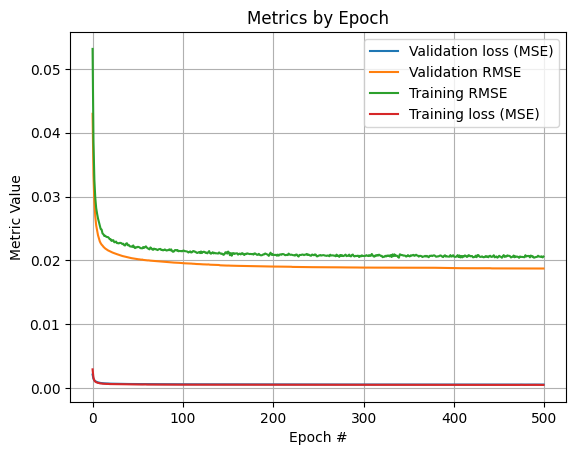

Metrics exported in the following csv file: logged_metrics/MultivariateNNtraining_metrics_22-05-2023_10-05-37.csv


In [5]:
input_space = train_dataloader.dataset.x.shape[1]
output_space = train_dataloader.dataset.y.shape[1]
print(f"{input_space=}\t{output_space=}")

class MultivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(MultivariateNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_space, 50),
            nn.ReLU(),
            nn.Linear(50, 500),
            nn.ReLU(),
            nn.Linear(500, output_space),
            nn.ReLU() #TODO?
        )
    
    def forward(self, x):
        return self.layers(x)
    
model = MultivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)

loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name="MultivariateNN training")
best_v_loss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_t_loss = 0
    epoch_t_rmse = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model.forward(input_features)
        tloss = loss_function(prediction, wake_field)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_t_loss += tloss.item()

        # other metrics
        rmse = metrics.field_based_rmse(prediction, wake_field).item()
        epoch_t_rmse += rmse

    avg_t_loss = epoch_t_loss / len(train_dataloader)
    avg_t_rmse = epoch_t_rmse / len(train_dataloader)
    metrics_logger.log_metric(epoch, 'Training loss (MSE)', avg_t_loss)
    metrics_logger.log_metric(epoch, 'Training RMSE', avg_t_rmse)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_v_loss = 0
        epoch_v_rmse = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(input_features)
            vloss = loss_function(prediction, wake_field)

            epoch_v_loss += vloss.item()
            rmse = metrics.field_based_rmse(prediction, wake_field).item()
            epoch_v_rmse += rmse

        avg_v_loss = epoch_v_loss / len(valid_dataloader)
        avg_v_rmse = epoch_v_rmse / len(valid_dataloader)
        metrics_logger.log_metric(epoch, 'Validation loss (MSE)', avg_v_loss)
        metrics_logger.log_metric(epoch, 'Validation RMSE', avg_v_rmse)
        # Track best performance, and save the model's state
        if avg_v_loss < best_v_loss:
            best_vloss = avg_v_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

In [7]:
# loading best model
model = MultivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.train(False)

total_loss = 0
with torch.no_grad():
    for batch in iter(test_dataloader):
        # to device
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)

        prediction = model(x)
        tloss = loss_function(prediction, y)

        total_loss += tloss.item()

avg_loss = total_loss / len(test_dataloader) / BATCH_SIZE #TODO
print(f"Testing results: avg loss={avg_loss}")

Testing results: avg loss=5.510379314391348e-05
